In [1]:
from scipy.optimize import minimize
import corner
import ptemcee
import subprocess
import pandas as pd
from joblib import Parallel, delayed

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import SIMS.run_simple_energy_loss_parallel as eloss
import GPy

In [3]:
simulation=eloss.run_simulation

In [4]:
pT_range = (1, 10, 10) # Compute more observable than needed to avoid boundry unstabilities.
pT_obs = [3, 5, 7] # p_T Observables we will use for the analysis

In [5]:
from emukit.core import ParameterSpace, ContinuousParameter

In [6]:
# old prior ranges
#prior_ranges= {'alpha_s':(0.05,0.5), 'exponent_inel':(-3,3), 'exponent_el':(-3,3), 'scale_inel':(0.1, 0.5), 'scale_el':(0.1, 0.5)}

prior_ranges= {'alpha_s':(0.1,0.4), 'exponent_inel':(-2,2), 'exponent_el':(-2,2), 'scale_inel':(0.1, 0.4), 'scale_el':(0.1, 0.4)}
true_values= {'alpha_s': 0.2, 'exponent_inel': -1, 'exponent_el': 1, 'scale_inel': 0.3, 'scale_el': 0.3}
name_to_position =  {'alpha_s':0, 'exponent_inel':1, 'exponent_el':2, 'scale_inel':3, 'scale_el':4}

In [7]:
# We will generate observable for these model parametr values and consider them as experimental data
# We will generate observables for these model parameter values and consider them as experimental data
truth = np.array([true_values['alpha_s'],  true_values['exponent_inel'],
                 true_values['exponent_el'],true_values['scale_inel'],true_values['scale_el']]).reshape(1,-1)

Text(0.5, 1.0, 'Experimental observations')

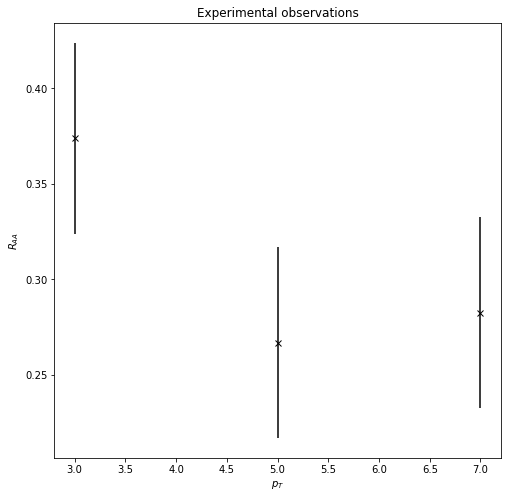

In [8]:
# Set seed for reproducibility.
seed = 42
np.random.seed(seed)

# Generate some synthetic data from the model.
x = np.array(pT_obs)
N = len(x)
obserr = 0.05 # Amplitude of noise term
obs = simulation(truth, *pT_range)[:,pT_obs] # True model
obs += obserr * np.random.randn(N) # Add some random noise

# Now plot it to see what the data looks like
fig, ax = plt.subplots(figsize=(8,8))

ax.errorbar(x.flatten(), obs.flatten(), yerr=obserr, fmt="xk", capsize=0)
#ax.plot(x.flatten(), obs.flatten(), "k", alpha=0.3, lw=3)
#ax.set_xlim(0, 10)
ax.set_xlabel(r"$p_T$")
ax.set_ylabel(r"$R_{AA}$")
ax.set_title('Experimental observations')

In [9]:
parameter_space = ParameterSpace([ContinuousParameter('alpha_s', 0.1,0.4 ),
                                  ContinuousParameter('exponent_inel', -2, 2),
                                  ContinuousParameter('exponent_el', -2, 2),
                                  ContinuousParameter('scale_inel', 0.1, 0.4),
                                  ContinuousParameter('scale_el', 0.1, 0.4)])

In [10]:
from emukit.core.initial_designs import LatinDesign

design = LatinDesign(parameter_space)
num_data_points = 20
X = design.get_samples(num_data_points)
print(f'Shape of X {X.shape}')

Shape of X (20, 5)


In [11]:
# Define the loglikelihood function
def logLikelihood(theta, x, obs, obserr):
  
    # Model parameters
    theta = np.array(theta)
    
    #alpha_s, mD_factor, exponent_inel, exponent_el = theta
    alpha_s, exp_inel, exp_el, sc_inel, sc_el = theta
    design = np.array([alpha_s, exp_inel, exp_el, sc_inel, sc_el]).reshape(1,-1)
    
    # Model predictions given parameters
    
    model = simulation(design,*pT_range)[:,x]#np.array([emu_predict0(design),emu_predict1(design),emu_predict2(design)],dtype=object)
    modelerr = np.array(0)#model[:,1]
    #model = model[:,0]
    
    # Likelihood of data given model parameters

    term2 = 0.5*(2*np.pi*np.sqrt(np.sum(obserr**2+modelerr.flatten()**2)))
    return -0.5*np.sum((obs.flatten()-model.flatten())**2/(obserr**2+modelerr.flatten()**2)) - term2

In [12]:
# Define the loglikelihood function
def Likelihood(theta, x, obs, obserr):
  
    # Model parameters
    theta = np.array(theta)
    
    #alpha_s, mD_factor, exponent_inel, exponent_el = theta
    alpha_s, exp_inel, exp_el, sc_inel, sc_el = theta
    design = np.array([alpha_s, exp_inel, exp_el, sc_inel, sc_el]).reshape(1,-1)
    
    # Model predictions given parameters
    
    model = simulation(design,*pT_range)[:,x]#np.array([emu_predict0(design),emu_predict1(design),emu_predict2(design)],dtype=object)
    modelerr = np.array(0)#model[:,1]
    #model = model[:,0]
    
    # Likelihood of data given model parameters

    term2 = 0.5*(2*np.pi*np.sqrt(np.sum(obserr**2+modelerr.flatten()**2)))
    return np.exp(-0.5*np.sum((obs.flatten()-model.flatten())**2/(obserr**2+modelerr.flatten()**2)) - term2)

In [13]:
def fl(design, pT=pT_obs):
    """returns likelihood function for a design matrix"""
    print(design)
    cores = 4
    like = Parallel(n_jobs=cores)(delayed(Likelihood)(theta, np.array(pT), obs, obserr) for theta in design)
#     like = [logLikelihood(theta, np.array(pT), obs, obserr) for theta in design]
    #observables=simulation(design,*pT_range)
    #Let's just return only one obsrvable for now. The middle p_T bin
    #return observables[:,pT]
    return np.array(like).reshape(-1,1)

def fll(design, pT=pT_obs):
    """returns likelihood function for a design matrix"""
    print(design)
    cores = 4
    like = Parallel(n_jobs=cores)(delayed(logLikelihood)(theta, np.array(pT), obs, obserr) for theta in design)
#     like = [logLikelihood(theta, np.array(pT), obs, obserr) for theta in design]
    #observables=simulation(design,*pT_range)
    #Let's just return only one obsrvable for now. The middle p_T bin
    #return observables[:,pT]
    return np.array(like).reshape(-1,1)

def f1(design, pT=pT_obs[0]):
    """returns simulation output for a design matrix"""
    print(design)
    observables=simulation(design,*pT_range)
    #Let's just return only one obsrvable for now. The middle p_T bin
    return observables[:,pT].reshape(-1,1)

def f2(design, pT=pT_obs[1]):
    """returns simulation output for a design matrix"""
    print(design)
    observables=simulation(design,*pT_range)
    #Let's just return only one obsrvable for now. The middle p_T bin
    return observables[:,pT].reshape(-1,1)

def f3(design, pT=pT_obs[2]):
    """returns simulation output for a design matrix"""
    print(design)
    observables=simulation(design,*pT_range)
    #Let's just return only one obsrvable for now. The middle p_T bin
    return observables[:,pT].reshape(-1,1)

fun=np.array([f1, f2, f3])
funl = np.array([fl])
funll = np.array([fll])

In [171]:
#Generate 5 random observables
Y = fll(X,pT_obs)

[[ 0.1525 -1.7     0.1     0.3775  0.2125]
 [ 0.2725 -1.5     1.5     0.1525  0.1075]
 [ 0.3175 -0.9     0.9     0.1075  0.3925]
 [ 0.2875  0.9     1.3     0.1375  0.3175]
 [ 0.3925  1.9    -0.5     0.2425  0.2875]
 [ 0.1225 -0.5    -0.9     0.3325  0.1525]
 [ 0.3475  1.1    -0.3     0.3925  0.1375]
 [ 0.2425 -0.3     0.7     0.2725  0.2275]
 [ 0.3025  0.1     1.7     0.1825  0.3625]
 [ 0.2275  1.7    -1.3     0.1975  0.1825]
 [ 0.1825  1.5    -1.1     0.2125  0.1225]
 [ 0.1975 -0.7     0.5     0.3025  0.3325]
 [ 0.2575  0.3    -1.7     0.3175  0.1675]
 [ 0.3625  1.3    -0.1     0.2575  0.3775]
 [ 0.1675  0.7     1.1     0.1225  0.2425]
 [ 0.3325 -1.9    -1.5     0.1675  0.2725]
 [ 0.1075  0.5    -0.7     0.3475  0.3025]
 [ 0.2125 -0.1    -1.9     0.2875  0.1975]
 [ 0.1375 -1.3     1.9     0.3625  0.3475]
 [ 0.3775 -1.1     0.3     0.2275  0.2575]]


In [173]:
np.save('initial-likelihood-gp-X-smallpriors-20pts',X)
np.save('initial-likelihood-gp-Y-smallpriors-20pts',Y)

In [14]:
X = np.load('initial-likelihood-gp-X-smallpriors-20pts.npy')
Y = np.load('initial-likelihood-gp-Y-smallpriors-20pts.npy')

In [15]:
from GPy.kern import RBF, White
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
#from multiprocessing import Pool

In [16]:
import emukit
emukit.experimental_design.acquisitions.__file__

'/home/mheffernan/Desktop/McGill/Research/PhD/Code/emukit/emukit/experimental_design/acquisitions/__init__.py'

## Time to get emulating

In [17]:
# size of possible variation of parameters
ptp = np.array([prior_ranges['alpha_s'][1],prior_ranges['exponent_inel'][1],prior_ranges['exponent_el'][1],prior_ranges['scale_inel'][1],prior_ranges['scale_el'][1]])\
-np.array([prior_ranges['alpha_s'][0],prior_ranges['exponent_inel'][0],prior_ranges['exponent_el'][0],prior_ranges['scale_inel'][0],prior_ranges['scale_el'][0]])

gp_array = []

#lengthscale = [0.08827045, 3.68405746, 380.55348423, 0.30696173, 1.38426181 ]
lengthscale = [0.08827045, 0.368405746, 0.155348423, 0.30696173, 0.38426181 ]
# for i,pt in enumerate(pT_obs):
rbf_kern =      RBF(  input_dim=5,
                      variance= 0.1,
                      lengthscale=lengthscale,
                      ARD=True)
my_kernel = rbf_kern
model_gpy = GPRegression(X=X,Y=Y.reshape(-1,1),kernel=my_kernel, noise_var=1e-2)
#model_gpy.optimize('bfgs', max_iters=200)
#for i in range(len(ptp)):
length_prior = GPy.core.parameterization.priors.Uniform(0.,10)

#model_gpy.kern.lengthscale.set_prior(length_prior)

#model_gpy.kern.lengthscale.constrain_bounded(0.,5,warning=False ) 

#model_gpy.optimize_restarts(num_restarts = 30)
model_emukit = GPyModelWrapper(model_gpy, n_restarts=50)
gp_array.append(model_emukit)

In [18]:
## Set some priors to make life better
model_emukit.model.Gaussian_noise.variance.set_prior(GPy.core.parameterization.priors.LogGaussian(2,.5))
model_emukit.model.rbf.variance.set_prior(GPy.core.parameterization.priors.LogGaussian(2,.5))
model_emukit.model.rbf.lengthscale.set_prior(GPy.core.parameterization.priors.LogGaussian(1,.5))

reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale


In [19]:
model_emukit.model

GP_regression.,value,constraints,priors
rbf.variance,0.1,+ve,"lnN(2, 0.5)"
rbf.lengthscale,"(5,)",+ve,"lnN(1, 0.5)"
Gaussian_noise.variance,0.01,+ve,"lnN(2, 0.5)"


In [20]:
model_emukit.model.rbf.lengthscale

index,GP_regression.rbf.lengthscale,constraints,priors
[0],0.08827045,+ve,"lnN(1, 0.5)"
[1],0.36840575,+ve,"lnN(1, 0.5)"
[2],0.15534842,+ve,"lnN(1, 0.5)"
[3],0.30696173,+ve,"lnN(1, 0.5)"
[4],0.38426181,+ve,"lnN(1, 0.5)"


In [21]:
cov = model_gpy.posterior_covariance_between_points(X[0].reshape(1,-1),X)

In [23]:
cornerpoint = np.array([ 0.1,  2., -2.,  0.4, 0.1]).reshape(1,-1)
tr = np.array([0.2, -1, 1, 0.3, 0.3]).reshape(1,-1)
prediction = model_gpy.predict(tr)
prediction_corner = model_gpy.predict(cornerpoint)

variance_prediction = np.sqrt((np.exp(prediction[0])*prediction[1])**2)
variance_prediction_corner = np.sqrt((np.exp(prediction_corner[0])*prediction_corner[1])**2)

In [24]:
print(np.mean(model_emukit.calculate_variance_reduction(cornerpoint,X)))
print(np.mean(model_emukit.calculate_variance_reduction(tr,X)))

2.9707963076300946e-15
2.635250414463413e-06


In [25]:
print(variance_prediction)
print(variance_prediction_corner)

[[0.00096968]]
[[0.11000363]]


In [26]:
print(np.mean(cov**2*variance_prediction_corner))
print(np.mean(cov**2*variance_prediction))

4.5456013168918387e-07
4.0069218721064555e-09


In [27]:
print(np.mean(np.exp(prediction_corner[0])))
print(np.mean(np.exp(prediction[0])))

1.0000330091365617
0.009327981854974084


In [28]:
from emukit.experimental_design.acquisitions import IntegratedExponentiatedVarianceReduction, ModelExpVariance
#from emukit.experimental_design.acquisitions importlib.reload(IntegratedExponentiatedVarianceReduction, ModelExpVariance)
from emukit.experimental_design import ExperimentalDesignLoop

In [29]:
#test_method = IntegratedExponentiatedVarianceReduction(model = model_emukit, space=parameter_space)
test_method = ModelExpVariance(model = model_emukit)

In [30]:
print(test_method.evaluate(tr))
print(test_method.evaluate(cornerpoint))

[[0.00096968]]
[[0.11000363]]


In [31]:
def logsubexp(x1, x2):
    """
    Numerically stable way to compute log(exp(x1) - exp(x2))

    logsubexp(x1, x2) -> log(exp(x1) - exp(x2))

    Parameters
    ----------
    x1 : float
    x2 : float

    Returns
    -------
    logsubexp(x1, x2)
    """

    if x1 <= x2:
        return -np.inf
    else:
        return x1 + np.log(1.0 - np.exp(x2 - x1))

In [32]:
def emu_predictl(X):
    y, variance_dy = model_emukit.predict(X)
    dy = np.sqrt(variance_dy)
    #y = scaler_0.inverse_transform(scaled_y)
    #dy = scaled_dy* scaler_0.scale_
    return y, dy.flatten()

In [33]:
def utility(x,t='naive'):
    """
    x: parameter set to predict
    
    returns
    --------
    utility function that says how useful this point is
    """
    if t=='naive':
        """
        Point is as useful as its naive exponentiated variance. 
        Don't care about tiny errors.
        """
        
        gp_y0, gp_dy0 = emu_predictl(x)
    
        naive_exp_variance = np.sqrt((np.exp(gp_y0)*gp_dy0)**2)

        return naive_exp_variance

    elif t=='Kandasamy':
        mu, var = emu_predictl(x)
        
        util = -((2.0 * mu + var) + logsubexp(var, 0.0))

        return util

    

In [34]:
def find_useful_points(num_adapt_points=25000,N=25,util='naive'):
    """
    num_adapt_points: number of points to probe the space with
    N: number of new points per round
    util: Utility to use to evalutate points. Options are naive and Kandasamy.
    
    Note: Should add a variance reduction option. Currently it's effectively max variance techniques.
    
    returns
    --------
    x_new_to_keep: new parameters that have a large utility
    
    """
    
    # same parameter space as defined previously
    adapt = LatinDesign(parameter_space) 
    X_new = adapt.get_samples(num_adapt_points)
    
    # same utility function as before
    utility_at_x_new = np.array([utility(np.array([x]),t=util) for x in X_new]).reshape(1,-1).flatten()
    
    K = utility_at_x_new.copy() # copy just to stay safe
    #store list in tmp to retrieve index
    tmp=list(K)
    K.sort()
    
    list_of_indices = [tmp.index(K[-i]) for i in range(N)]
    x_new_to_keep = np.array([X_new[list_of_indices[i]] for i in range(N)])
    
    return x_new_to_keep
    

In [35]:
from scipy.optimize import basinhopping

def print_fun(x, f, accepted):
    global hop_x
    hop_x.append(x)
    #print(f"at xminimum {x} accepted {int(accepted)}")

def basinutil():


    ## okay, but we want to constrain our regions

    # the bounds
    xmin = [prior_ranges[key][0] for key in prior_ranges.keys()]
    xmax = [prior_ranges[key][1] for key in prior_ranges.keys()]

    # starting guess in the middle of parameter space
    x0 = [xmax[i]-0.5*(xmax[i]-xmin[i]) for i in range(len(xmin))]

    # rewrite the bounds in the way required by L-BFGS-B
    bounds = [(low, high) for low, high in zip(xmin, xmax)]

    # use method L-BFGS-B because the problem is smooth and bounded
    minimizer_kwargs = dict(method="L-BFGS-B", bounds=bounds)
    
    utility_min = lambda x: float(-utility(np.array([x])))
    
    res = basinhopping(utility_min, x0, minimizer_kwargs=minimizer_kwargs,callback=print_fun)
    
    return res.x

In [36]:
from scipy.optimize import fminbound

def findmultipleopts(num_adapt_points=2500,N=25):
    """
    num_adapt_points: number of points to probe the space with
    N: number of new points per round
    
    Note: Should add a variance reduction option. Currently it's effectively max variance techniques.
    
    returns
    --------
    x_new_to_keep: new parameters that have a large utility
    
    """
    
    # the bounds
    xmin = [prior_ranges[key][0] for key in prior_ranges.keys()]
    xmax = [prior_ranges[key][1] for key in prior_ranges.keys()]

    # starting guess in the middle of parameter space
    x0 = [xmax[i]-0.5*(xmax[i]-xmin[i]) for i in range(len(xmin))]

    # rewrite the bounds in the way required by L-BFGS-B
    bounds = [(low, high) for low, high in zip(xmin, xmax)]
    
    sub_regions = np.array([])
    
    for i in range(min(N,len(bounds))):
        subreg = bounds
        subreg[i] = (x0,xmax)
        np.vstack(sub_regions,subreg)
        subreg[i] = (xmin, x0)
        np.vstack(sub_regions,subreg)
        
    new_xs = []    
    for row in sub_regions:
        new_xs.append(fminbound(utility))
    
    # same parameter space as defined previously
    adapt = LatinDesign(parameter_space) 
    X_new = adapt.get_samples(num_adapt_points)
    
    # same utility function as before
    utility_at_x_new = np.array([utility(np.array([x]),t='naive') for x in X_new]).reshape(1,-1).flatten()
    print(utility_at_x_new)
    peakinds = find_peaks(utility_at_x_new,distance=5) # requires a minimum distance between peaks
    print(peakinds)
    
    #K = utility_at_x_new.copy() # copy just to stay safe
    
    #store list in tmp to retrieve index
    #tmp=list(K)
    #K.sort()
    
    
    
    
    #list_of_indices = [tmp.index(K[-i]) for i in range(N)]
    #x_new_to_keep = np.array([X_new[list_of_indices[i]] for i in range(N)])
    
    #return x_new_to_keep
    

In [41]:
def matt_design_loop(num_adapt_points=2500,N=25,util='naive'):
    """
    Design loop that attempts to find points that are useful
    
    Utility options: naive, Kandasamy, BasinKandasamy
    
    BasinKandasamy uses Basin Hopping to find a global minimum
    but can only find a single point per iteration. It therefore runs in a loop
    reoptimizing each time. This way it can be called similarly
    """
    
    model_emukit.optimize() # fit our GP to start
    if util == 'naive' or util == 'Kandasamy':
        xnew = find_useful_points(num_adapt_points=num_adapt_points,N=N,util=util)
        ynew = fll(xnew) # calculate the new points
        print(ynew)
        X_update = np.vstack((np.array(model_emukit.X),xnew)) # concatenate arrays
        Y_update = np.vstack((np.array(model_emukit.Y),ynew))
        model_emukit.set_data(X_update,Y_update) # update GP model dataset
        model_emukit.optimize() # reoptimize
        
        
    elif util == 'BasinKandasamy':
        # This attempt to be more clever about the whole thing is somewhat of a dud
        global hop_x
        hop_x = []

        xnew = basinutil().reshape(1,-1)
        hoparray = np.unique(np.array(hop_x),axis=0)
        x_to_try = np.unique(np.around(np.vstack((xnew,hoparray)),3),axis=0)
        
        # ensure we don't already have points in array and only consider new points
        intsect = np.intersect1d(model_emukit.X,x_to_try)
        c = (x_to_try==intsect)
        d = [x.all() for x in c]
        e = [not x for x in d]
        x_to_try = x_to_try[e]
        
        util_at_x_new = utility(x_to_try)
        K = util_at_x_new.copy()[:,0] # copy just to stay safe

        #store list in tmp to retrieve index
        tmp=list(K)
        K.sort()
        
        testlist_of_indices = [K[-i] for i in range(N)]

        list_of_indices = [tmp.index(K[-i]) for i in range(N)]
        x_new_to_keep = np.array([x_to_try[list_of_indices[i]] for i in range(N)])

        xnew = x_new_to_keep
        ynew = fll(xnew)
        X_update = np.vstack((np.array(model_emukit.X),xnew)) # concatenate arrays
        Y_update = np.vstack((np.array(model_emukit.Y),ynew))
        model_emukit.set_data(X_update,Y_update) # update GP model dataset
        model_emukit.optimize() # reoptimize

    

In [38]:
model_emukit.X.shape

(20, 5)

In [39]:
model_emukit.optimize()

Optimization restart 1/50, f = 161.31574196598828
Optimization restart 2/50, f = 161.3157419659646


 /home/mheffernan/anaconda3/lib/python3.8/site-packages/paramz/transformations.py:119: RuntimeWarning:overflow encountered in expm1
 /home/mheffernan/anaconda3/lib/python3.8/site-packages/paramz/transformations.py:121: RuntimeWarning:overflow encountered in expm1


Optimization restart 3/50, f = 161.31574197509235
Optimization restart 4/50, f = 161.31574196999804
Optimization restart 5/50, f = 161.3157419674774
Optimization restart 6/50, f = 161.31574196631178
Optimization restart 7/50, f = 161.31574196927528
Optimization restart 8/50, f = 166.56005735314662
Optimization restart 9/50, f = 161.3157420013918


 /home/mheffernan/anaconda3/lib/python3.8/site-packages/GPy/core/parameterization/priors.py:182: RuntimeWarning:overflow encountered in true_divide


Optimization restart 10/50, f = 161.31574196733936
Optimization restart 11/50, f = 161.3157419713994
Optimization restart 12/50, f = 168.15368524433714
Optimization restart 13/50, f = 161.31574197577822
Optimization restart 14/50, f = 161.31574196964272
Optimization restart 15/50, f = 161.3157419719676
Optimization restart 16/50, f = 166.71575327845818
Optimization restart 17/50, f = 161.31574197013407
Optimization restart 18/50, f = 161.3157419658909
Optimization restart 19/50, f = 169.75005436317733
Optimization restart 20/50, f = 163.8457235752106
Optimization restart 21/50, f = 161.31574196797413
Optimization restart 22/50, f = 161.31574197805392
Optimization restart 23/50, f = 161.3157419668617
Optimization restart 24/50, f = 161.31574196661614
Optimization restart 25/50, f = 161.31574196641697


 /home/mheffernan/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 26/50, f = 173.0194795104931
Optimization restart 27/50, f = 170.178478116119
Optimization restart 28/50, f = 161.31574206615687
Optimization restart 29/50, f = 161.3157419984521
Optimization restart 30/50, f = 176.22339111326812
Optimization restart 31/50, f = 161.31574197303527
Optimization restart 32/50, f = 161.31574196602196
Optimization restart 33/50, f = 161.3157419669416
Optimization restart 34/50, f = 161.31574196721377
Optimization restart 35/50, f = 161.3157419662021
Optimization restart 36/50, f = 161.31574197987794
Optimization restart 37/50, f = 161.31574196653384
Optimization restart 38/50, f = 161.3157419685035
Optimization restart 39/50, f = 161.31574196803408
Optimization restart 40/50, f = 161.31574198883848
Optimization restart 41/50, f = 161.31574196613627
Optimization restart 42/50, f = 161.31574196808572
Optimization restart 43/50, f = 161.3157419721781
Optimization restart 44/50, f = 161.31574196604137
Optimization restart 45/50, f = 161.315

In [46]:
find_useful_points(num_adapt_points=500,N=10,util='naive')

array([[ 0.2185,  0.092 , -0.372 ,  0.2359,  0.2779],
       [ 0.1225, -1.796 ,  1.948 ,  0.1411,  0.1993],
       [ 0.2581, -1.748 ,  1.972 ,  0.2941,  0.1735],
       [ 0.2947, -1.836 ,  1.812 ,  0.2911,  0.3403],
       [ 0.1141, -1.908 ,  1.692 ,  0.1285,  0.1309],
       [ 0.2011, -1.86  ,  1.716 ,  0.2737,  0.3169],
       [ 0.2353,  1.804 ,  1.98  ,  0.3265,  0.2545],
       [ 0.1237, -1.5   ,  1.956 ,  0.1651,  0.1903],
       [ 0.1363, -1.916 ,  1.628 ,  0.3691,  0.1213],
       [ 0.2497, -1.636 ,  1.844 ,  0.1327,  0.2149]])

In [51]:
for j in range(5):
    print(f'Loop {j}')
    npoint = int(500*(j+1))
    print(npoint)
    #matt_design_loop(N=10,util='Kandasamy')
    matt_design_loop(num_adapt_points=5000,N=10,util='naive')

Loop 0
500
Optimization restart 1/50, f = 161.31574196584643
Optimization restart 2/50, f = 161.31574198571883
Optimization restart 3/50, f = 161.31574202736297


 /home/mheffernan/anaconda3/lib/python3.8/site-packages/paramz/transformations.py:119: RuntimeWarning:overflow encountered in expm1
 /home/mheffernan/anaconda3/lib/python3.8/site-packages/paramz/transformations.py:121: RuntimeWarning:overflow encountered in expm1


Optimization restart 4/50, f = 161.3157419658704
Optimization restart 5/50, f = 161.31574196855715
Optimization restart 6/50, f = 161.31574196678287
Optimization restart 7/50, f = 161.31574196844218
Optimization restart 8/50, f = 161.315741970716
Optimization restart 9/50, f = 161.31574196710352
Optimization restart 10/50, f = 161.31574196600207
Optimization restart 11/50, f = 161.31574196597563
Optimization restart 12/50, f = 161.3157419672193
Optimization restart 13/50, f = 161.31574196649493
Optimization restart 14/50, f = 161.3157420008398
Optimization restart 15/50, f = 161.31574196585458
Optimization restart 16/50, f = 161.315741984587
Optimization restart 17/50, f = 161.31574196906132
Optimization restart 18/50, f = 161.3157419676789
Optimization restart 19/50, f = 161.315741967814
Optimization restart 20/50, f = 161.31574196723767
Optimization restart 21/50, f = 161.31574207949097
Optimization restart 22/50, f = 161.31574196592499
Optimization restart 23/50, f = 161.31574196631

 /home/mheffernan/anaconda3/lib/python3.8/site-packages/GPy/core/parameterization/priors.py:182: RuntimeWarning:overflow encountered in true_divide


Optimization restart 35/50, f = 168.53414300376784
Optimization restart 36/50, f = 161.31574197055937
Optimization restart 37/50, f = 161.31574196594227
Optimization restart 38/50, f = 166.5824660093746
Optimization restart 39/50, f = 161.31574196634236
Optimization restart 40/50, f = 161.3157419659192
Optimization restart 41/50, f = 161.31574197016926
Optimization restart 42/50, f = 174.89916724831832


 /home/mheffernan/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 43/50, f = 161.31574197830474
Optimization restart 44/50, f = 161.31574205500254
Optimization restart 45/50, f = 166.6558208871314
Optimization restart 46/50, f = 161.31574215989872
Optimization restart 47/50, f = 169.4599522182507
Optimization restart 48/50, f = 161.31574196681305
Optimization restart 49/50, f = 161.31574196958297
Optimization restart 50/50, f = 161.31574199715288
[[ 0.17899  0.1068  -0.3172   0.26827  0.27751]
 [ 0.26587 -1.9676   1.994    0.26053  0.34081]
 [ 0.25741 -1.962    1.99     0.33463  0.31915]
 [ 0.20671 -1.9692   1.9732   0.31279  0.20695]
 [ 0.26731 -1.9988   1.9268   0.34105  0.37351]
 [ 0.39901 -1.958    1.9484   0.32695  0.31603]
 [ 0.37819 -1.9028   1.9892   0.25411  0.20881]
 [ 0.11899 -1.8596   1.9972   0.38467  0.22747]
 [ 0.23023 -1.8868   1.9636   0.36181  0.24247]
 [ 0.30433 -1.8612   1.9756   0.35401  0.38365]]
[[-13.24509088]
 [-36.11038488]
 [-45.48592737]
 [-20.0866161 ]
 [-50.31999949]
 [-58.14115294]
 [-56.06184666]
 

 /home/mheffernan/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/mheffernan/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 31/50, f = 254.09308282880764
Optimization restart 32/50, f = 254.09308285891575
Optimization restart 33/50, f = 254.09308287383033
Optimization restart 34/50, f = 254.09308282790454
Optimization restart 35/50, f = 254.093082830806
Optimization restart 36/50, f = 254.09308283125915
Optimization restart 37/50, f = 254.09308282869858
Optimization restart 38/50, f = 254.09308293523065
Optimization restart 39/50, f = 254.09308546376403
Optimization restart 40/50, f = 254.09308391078198
Optimization restart 41/50, f = 254.09308283268786
Optimization restart 42/50, f = 254.0930828283609
Optimization restart 43/50, f = 254.0930828277273
Optimization restart 44/50, f = 254.09308282855397
Optimization restart 45/50, f = 254.09308282766324
Optimization restart 46/50, f = 254.09308285916015
Optimization restart 47/50, f = 254.0930828284404
Optimization restart 48/50, f = 254.09308282844563
Optimization restart 49/50, f = 254.09308282812782
Optimization restart 50/50, f = 254.

 /home/mheffernan/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 43/50, f = 317.39365554784354
Optimization restart 44/50, f = 325.03079119731854
Optimization restart 45/50, f = 317.3936555483812
Optimization restart 46/50, f = 317.39365555784593
Optimization restart 47/50, f = 317.39365554472016
Optimization restart 48/50, f = 317.3936556137481
Optimization restart 49/50, f = 317.39365560999863
Optimization restart 50/50, f = 317.3936555441077
Loop 3
2000
Optimization restart 1/50, f = 308.2134623247649
Optimization restart 2/50, f = 317.3936555611928


 /home/mheffernan/anaconda3/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 3/50, f = 332.23931795104085
Optimization restart 4/50, f = 317.3936555946977
Optimization restart 5/50, f = 317.39365564796867
Optimization restart 6/50, f = 317.3936555456465
Optimization restart 7/50, f = 317.3936555468778
Optimization restart 8/50, f = 317.3936555869131
Optimization restart 9/50, f = 308.2134623312023
Optimization restart 10/50, f = 327.436370020644
Optimization restart 11/50, f = 333.79456090276256
Optimization restart 12/50, f = 336.22201245431177
Optimization restart 13/50, f = 317.3936555477793
Optimization restart 14/50, f = 317.3936555446993
Optimization restart 15/50, f = 317.393655545826
Optimization restart 16/50, f = 317.3936555467552
Optimization restart 17/50, f = 317.3936555666342
Optimization restart 18/50, f = 326.7120154416486
Optimization restart 19/50, f = 317.3936555444349
Optimization restart 20/50, f = 317.39365556872576
Optimization restart 21/50, f = 317.39365555693604
Optimization restart 22/50, f = 317.39365557319735
Op

[[-160.84000577]
 [  -8.67593421]
 [ -18.59733969]
 [ -11.44229462]
 [ -14.65145967]
 [  -4.32295819]
 [ -15.33622354]
 [  -2.30113744]
 [  -2.50950562]
 [ -23.04068776]]
Optimization restart 1/50, f = 382.3595494551024
Optimization restart 2/50, f = 382.35920335631295
Optimization restart 3/50, f = 444.81517736827584
Optimization restart 4/50, f = 453.818828941172
Optimization restart 5/50, f = 399.1142198943339
Optimization restart 6/50, f = 382.3592032098535
Optimization restart 7/50, f = 440.7205738737391
Optimization restart 8/50, f = 399.50213175417457
Optimization restart 9/50, f = 395.6457015708564
Optimization restart 10/50, f = 382.35920319036603
Optimization restart 11/50, f = 382.35920318489
Optimization restart 12/50, f = 469.85155067042626
Optimization restart 13/50, f = 432.24086706981035
Optimization restart 14/50, f = 432.2408670955366
Optimization restart 15/50, f = 417.5595221876377
Optimization restart 16/50, f = 382.3592032059486
Optimization restart 17/50, f = 382

In [52]:
model_emukit.X.shape

(70, 5)

In [52]:
np.save('likelihood-gp-X-100pts-priors-mattloop',model_emukit.X)
np.save('likelihood-gp-Y-100pts-priors-mattloop',model_emukit.Y)

In [203]:
basinutil()

 <ipython-input-118-00964ff73c14>:3: RuntimeWarning:invalid value encountered in sqrt


array([0.25, 0.  , 0.  , 0.25, 0.25])

In [201]:
findpeaks()

 <ipython-input-118-00964ff73c14>:3: RuntimeWarning:invalid value encountered in sqrt


[nan nan nan ... nan nan nan]
(array([], dtype=int64), {})


In [53]:
plt.figure(figsize=(7,5))

# let's visualize on some edges

# emutestpts = np.array([[x,-1.99,1.99,0.3,0.3] for x in \
#                        np.linspace(prior_ranges['alpha_s'][0],prior_ranges['alpha_s'][1],n_plot_pts)])

dim = 2
emutestpts = np.array([[0.2,-1,x,0.3,0.4] for x in \
                       np.linspace(-2,2,n_plot_pts)])
gp_y0, gp_dy0 = emu_predictl(emutestpts)

#print(emu_predictl(np.array([emutestpts[0]])))
#print(utility(np.array([x for x in emutestpts])))

utility_min = lambda x: float(-utility(np.array([x]),t='Kandasamy'))

#util_pts = np.array([utility(np.array([x]))  for x in emutestpts]).reshape(1,-1).flatten()

util_pts = np.array([utility_min(x)  for x in emutestpts]).reshape(1,-1).flatten()

#print(np.array(util_pts).reshape(1,-1).flatten())

plt.plot(emutestpts[:,dim], gp_y0[:,0], color='red', label='emulated loglikelihood')
plt.fill_between(emutestpts[:,dim], y1 = gp_y0[:,0] - 1.*gp_dy0, y2 = gp_y0[:,0] + 1.*gp_dy0, 
                 interpolate=True, alpha=0.3, label=r'GP 1$\sigma$', color='red')

#plt.plot(emutestpts[:,0], np.exp(gp_y0[:,0]), color='red', label='emulated likelihood')
#plt.fill_between(emutestpts[:,0], y1 = np.exp(gp_y0[:,0]) - 1.*np.sqrt((np.exp(gp_y0[:,0])*gp_dy0)**2), y2 = np.exp(gp_y0[:,0]) + 1.*np.sqrt((np.exp(gp_y0[:,0])*gp_dy0)**2), 
#                 interpolate=True, alpha=0.3, label=r'GP 1$\sigma$', color='red')

plt.plot(emutestpts[:,dim], util_pts, color='green', label='utility')

plt.title('Scanning edge of parameter space')
plt.grid(True)
plt.legend()

plt.show()

NameError: name 'n_plot_pts' is not defined

<Figure size 504x360 with 0 Axes>

In [54]:
#make a regular grid to plot our Emulator predictions
n_plot_pts = 100
sim_pnt = 10
test_points = np.array([[x,true_values['exponent_inel'],
                 true_values['exponent_el'],true_values['scale_inel'],true_values['scale_el']] for x in np.linspace(prior_ranges['alpha_s'][0],prior_ranges['alpha_s'][1],n_plot_pts)])
simulation_out = fll(test_points[np.arange(0,n_plot_pts,sim_pnt),:],pT=pT_obs)#[:,pT_obs]

[[ 0.1        -1.          1.          0.3         0.3       ]
 [ 0.13030303 -1.          1.          0.3         0.3       ]
 [ 0.16060606 -1.          1.          0.3         0.3       ]
 [ 0.19090909 -1.          1.          0.3         0.3       ]
 [ 0.22121212 -1.          1.          0.3         0.3       ]
 [ 0.25151515 -1.          1.          0.3         0.3       ]
 [ 0.28181818 -1.          1.          0.3         0.3       ]
 [ 0.31212121 -1.          1.          0.3         0.3       ]
 [ 0.34242424 -1.          1.          0.3         0.3       ]
 [ 0.37272727 -1.          1.          0.3         0.3       ]]


 <ipython-input-56-9344675b64be>:22: MatplotlibDeprecationWarning:Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


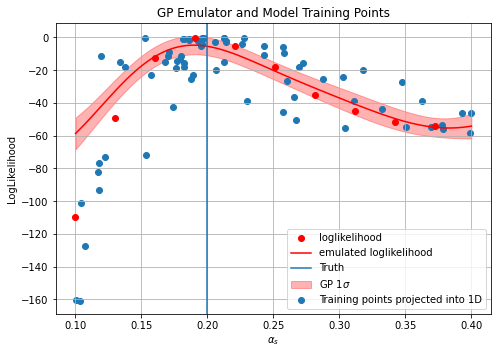

In [56]:
plt.figure(figsize=(7,5))

plt.plot(test_points[np.arange(0,n_plot_pts,sim_pnt),0], simulation_out[:,0],'ro', label='loglikelihood')

#get the GP Emulator's predictions of both the mean and std. deviation
gp_y0, gp_dy0 = emu_predictl(test_points)


plt.plot(test_points[:,0], gp_y0[:,0], color='red', label='emulated loglikelihood')
plt.fill_between(test_points[:,0], y1 = gp_y0[:,0] - 1.*gp_dy0, y2 = gp_y0[:,0] + 1.*gp_dy0, 
                 interpolate=True, alpha=0.3, label=r'GP 1$\sigma$', color='red')

plt.scatter(model_emukit.X[:,0],model_emukit.Y,label='Training points projected into 1D')

plt.axvline(true_values['alpha_s'],label='Truth')

plt.xlabel(r'$\alpha_s$')
plt.ylabel(r'LogLikelihood')
plt.title(r'GP Emulator and Model Training Points')
plt.legend()
plt.grid(True)
plt.tight_layout(True)

plt.show()

 <ipython-input-57-9e1488416b74>:19: MatplotlibDeprecationWarning:Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


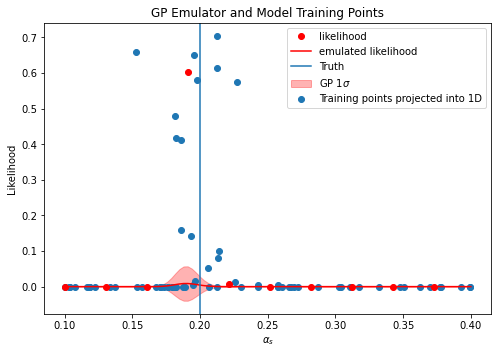

In [57]:
plt.figure(figsize=(7,5))
plt.plot(test_points[np.arange(0,n_plot_pts,sim_pnt),0], np.exp(simulation_out[:,0]),'ro', label='likelihood')

#get the GP Emulator's predictions of both the mean and std. deviation
gp_y0, gp_dy0 = emu_predictl(test_points)

plt.plot(test_points[:,0], np.exp(gp_y0[:,0]), color='red', label='emulated likelihood')
plt.fill_between(test_points[:,0], y1 = np.exp(gp_y0[:,0]) - 1.*np.sqrt((np.exp(gp_y0[:,0])*gp_dy0)**2), y2 = np.exp(gp_y0[:,0]) + 1.*np.sqrt((np.exp(gp_y0[:,0])*gp_dy0)**2), 
                 interpolate=True, alpha=0.3, label=r'GP 1$\sigma$', color='red')

plt.axvline(true_values['alpha_s'],label='Truth')
plt.scatter(gp_array[0].X[:,0],np.exp(gp_array[0].Y),label='Training points projected into 1D')

plt.xlabel(r'$\alpha_s$')
plt.ylabel(r'Likelihood')
plt.title(r'GP Emulator and Model Training Points')
#plt.ylim(0,1)
plt.legend()
plt.tight_layout(True)

plt.show()

In [379]:
#make a regular grid to plot our Emulator predictions
n_plot_pts = 100
sim_pnt = 10
test_points2 = np.array([[true_values['alpha_s'],x,
                 true_values['exponent_el'],true_values['scale_inel'],true_values['scale_el']] for x in np.linspace(prior_ranges['exponent_inel'][0],prior_ranges['exponent_inel'][1],n_plot_pts)])
simulation_out2 = fll(test_points2[np.arange(0,n_plot_pts,sim_pnt),:],pT=pT_obs)#[:,pT_obs]

[[ 0.2        -2.          1.          0.3         0.3       ]
 [ 0.2        -1.5959596   1.          0.3         0.3       ]
 [ 0.2        -1.19191919  1.          0.3         0.3       ]
 [ 0.2        -0.78787879  1.          0.3         0.3       ]
 [ 0.2        -0.38383838  1.          0.3         0.3       ]
 [ 0.2         0.02020202  1.          0.3         0.3       ]
 [ 0.2         0.42424242  1.          0.3         0.3       ]
 [ 0.2         0.82828283  1.          0.3         0.3       ]
 [ 0.2         1.23232323  1.          0.3         0.3       ]
 [ 0.2         1.63636364  1.          0.3         0.3       ]]


 <ipython-input-420-7e5a822b8ae0>:21: MatplotlibDeprecationWarning:Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


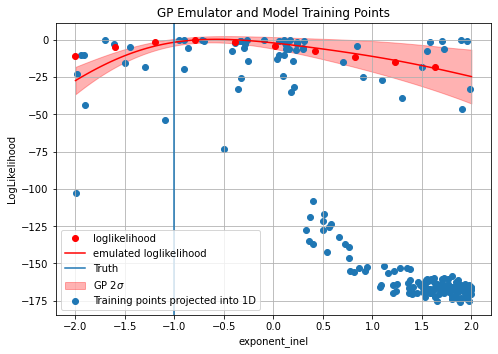

In [420]:
plt.figure(figsize=(7,5))

plt.plot(test_points2[np.arange(0,n_plot_pts,sim_pnt),1], simulation_out2[:,0],'ro', label='loglikelihood')

#get the GP Emulator's predictions of both the mean and std. deviation
gp_y0, gp_dy0 = emu_predictl(test_points2)

plt.plot(test_points2[:,1], gp_y0[:,0], color='red', label='emulated loglikelihood')
plt.fill_between(test_points2[:,1], y1 = gp_y0[:,0] - 2.*gp_dy0, y2 = gp_y0[:,0] + 2.*gp_dy0, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='red')

plt.scatter(gp_array[0].X[:,1],gp_array[0].Y,label='Training points projected into 1D')

plt.axvline(true_values['exponent_inel'],label='Truth')

plt.xlabel(r'exponent_inel')
plt.ylabel(r'LogLikelihood')
plt.title(r'GP Emulator and Model Training Points')
plt.legend()
plt.grid(True)
plt.tight_layout(True)

plt.show()

 <ipython-input-421-c9bce81d9d6f>:19: MatplotlibDeprecationWarning:Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


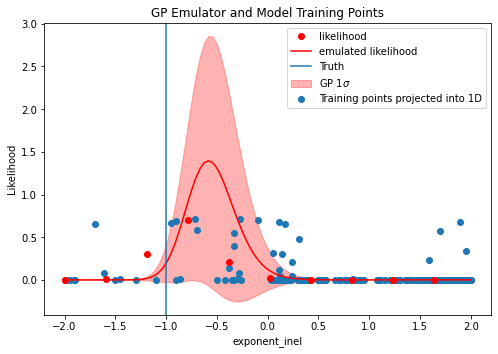

In [421]:
plt.figure(figsize=(7,5))
plt.plot(test_points2[np.arange(0,n_plot_pts,sim_pnt),1], np.exp(simulation_out2[:,0]),'ro', label='likelihood')

#get the GP Emulator's predictions of both the mean and std. deviation
gp_y0, gp_dy0 = emu_predictl(test_points2)

plt.plot(test_points2[:,1], np.exp(gp_y0[:,0]), color='red', label='emulated likelihood')
plt.fill_between(test_points2[:,1], y1 = np.exp(gp_y0[:,0]) - 1.*np.sqrt((np.exp(gp_y0[:,0])*gp_dy0)**2), y2 = np.exp(gp_y0[:,0]) + 1.*np.sqrt((np.exp(gp_y0[:,0])*gp_dy0)**2), 
                 interpolate=True, alpha=0.3, label=r'GP 1$\sigma$', color='red')

plt.axvline(true_values['exponent_inel'],label='Truth')
plt.scatter(gp_array[0].X[:,1],np.exp(gp_array[0].Y),label='Training points projected into 1D')

plt.xlabel(r'exponent_inel')
plt.ylabel(r'Likelihood')
plt.title(r'GP Emulator and Model Training Points')
#plt.ylim(0,1)
plt.legend()
plt.tight_layout(True)

plt.show()

In [382]:
#make a regular grid to plot our Emulator predictions
n_plot_pts = 100
sim_pnt = 10
test_points3 = np.array([[true_values['alpha_s'],true_values['exponent_inel'],x,
                 true_values['scale_inel'],true_values['scale_el']] for x in np.linspace(prior_ranges['exponent_el'][0],prior_ranges['exponent_el'][1],n_plot_pts)])
simulation_out3 = fll(test_points3[np.arange(0,n_plot_pts,sim_pnt),:],pT=pT_obs)#[:,pT_obs]

[[ 0.2        -1.         -2.          0.3         0.3       ]
 [ 0.2        -1.         -1.5959596   0.3         0.3       ]
 [ 0.2        -1.         -1.19191919  0.3         0.3       ]
 [ 0.2        -1.         -0.78787879  0.3         0.3       ]
 [ 0.2        -1.         -0.38383838  0.3         0.3       ]
 [ 0.2        -1.          0.02020202  0.3         0.3       ]
 [ 0.2        -1.          0.42424242  0.3         0.3       ]
 [ 0.2        -1.          0.82828283  0.3         0.3       ]
 [ 0.2        -1.          1.23232323  0.3         0.3       ]
 [ 0.2        -1.          1.63636364  0.3         0.3       ]]


 <ipython-input-422-e7215cd93aa3>:21: MatplotlibDeprecationWarning:Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


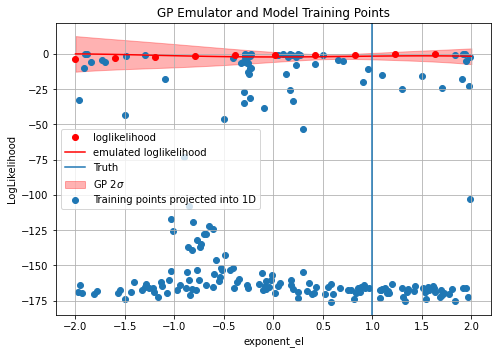

In [422]:
plt.figure(figsize=(7,5))

plt.plot(test_points3[np.arange(0,n_plot_pts,sim_pnt),2], simulation_out3[:,0],'ro', label='loglikelihood')

#get the GP Emulator's predictions of both the mean and std. deviation
gp_y0, gp_dy0 = emu_predictl(test_points3)

plt.plot(test_points3[:,2], gp_y0[:,0], color='red', label='emulated loglikelihood')
plt.fill_between(test_points3[:,2], y1 = gp_y0[:,0] - 2.*gp_dy0, y2 = gp_y0[:,0] + 2.*gp_dy0, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='red')

plt.scatter(gp_array[0].X[:,2],gp_array[0].Y,label='Training points projected into 1D')

plt.axvline(true_values['exponent_el'],label='Truth')

plt.xlabel(r'exponent_el')
plt.ylabel(r'LogLikelihood')
plt.title(r'GP Emulator and Model Training Points')
plt.legend()
plt.grid(True)
plt.tight_layout(True)

plt.show()

 <ipython-input-423-780f4fe728fc>:19: MatplotlibDeprecationWarning:Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


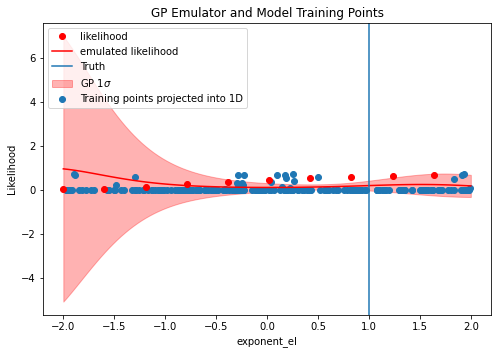

In [423]:
plt.figure(figsize=(7,5))
plt.plot(test_points3[np.arange(0,n_plot_pts,sim_pnt),2], np.exp(simulation_out3[:,0]),'ro', label='likelihood')

#get the GP Emulator's predictions of both the mean and std. deviation
gp_y0, gp_dy0 = emu_predictl(test_points3)

plt.plot(test_points3[:,2], np.exp(gp_y0[:,0]), color='red', label='emulated likelihood')
plt.fill_between(test_points3[:,2], y1 = np.exp(gp_y0[:,0]) - 1.*np.sqrt((np.exp(gp_y0[:,0])*gp_dy0)**2), y2 = np.exp(gp_y0[:,0]) + 1.*np.sqrt((np.exp(gp_y0[:,0])*gp_dy0)**2), 
                 interpolate=True, alpha=0.3, label=r'GP 1$\sigma$', color='red')

plt.axvline(true_values['exponent_el'],label='Truth')
plt.scatter(gp_array[0].X[:,2],np.exp(gp_array[0].Y),label='Training points projected into 1D')

plt.xlabel(r'exponent_el')
plt.ylabel(r'Likelihood')
plt.title(r'GP Emulator and Model Training Points')
#plt.ylim(0,1)
plt.legend()
plt.tight_layout(True)

plt.show()

In [385]:
#make a regular grid to plot our Emulator predictions
n_plot_pts = 100
sim_pnt = 10
test_points4 = np.array([[true_values['alpha_s'],true_values['exponent_inel'],true_values['exponent_el'],
                 x,true_values['scale_el']] for x in np.linspace(prior_ranges['scale_inel'][0],prior_ranges['scale_inel'][1],n_plot_pts)])
simulation_out4 = fll(test_points4[np.arange(0,n_plot_pts,sim_pnt),:],pT=pT_obs)#[:,pT_obs]

[[ 0.2        -1.          1.          0.1         0.3       ]
 [ 0.2        -1.          1.          0.13030303  0.3       ]
 [ 0.2        -1.          1.          0.16060606  0.3       ]
 [ 0.2        -1.          1.          0.19090909  0.3       ]
 [ 0.2        -1.          1.          0.22121212  0.3       ]
 [ 0.2        -1.          1.          0.25151515  0.3       ]
 [ 0.2        -1.          1.          0.28181818  0.3       ]
 [ 0.2        -1.          1.          0.31212121  0.3       ]
 [ 0.2        -1.          1.          0.34242424  0.3       ]
 [ 0.2        -1.          1.          0.37272727  0.3       ]]


 <ipython-input-424-ba10a5c63882>:21: MatplotlibDeprecationWarning:Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


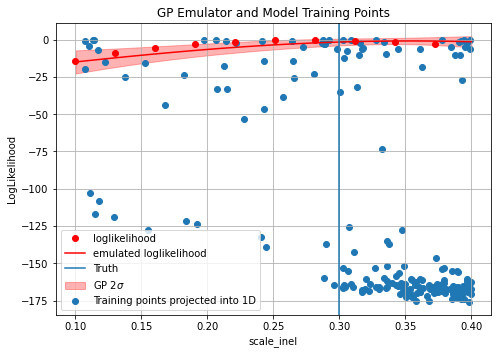

In [424]:
plt.figure(figsize=(7,5))

plt.plot(test_points4[np.arange(0,n_plot_pts,sim_pnt),3], simulation_out4[:,0],'ro', label='loglikelihood')

#get the GP Emulator's predictions of both the mean and std. deviation
gp_y0, gp_dy0 = emu_predictl(test_points4)

plt.plot(test_points4[:,3], gp_y0[:,0], color='red', label='emulated loglikelihood')
plt.fill_between(test_points4[:,3], y1 = gp_y0[:,0] - 2.*gp_dy0, y2 = gp_y0[:,0] + 2.*gp_dy0, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='red')

plt.scatter(gp_array[0].X[:,3],gp_array[0].Y,label='Training points projected into 1D')

plt.axvline(true_values['scale_inel'],label='Truth')

plt.xlabel(r'scale_inel')
plt.ylabel(r'LogLikelihood')
plt.title(r'GP Emulator and Model Training Points')
plt.legend()
plt.grid(True)
plt.tight_layout(True)

plt.show()

 <ipython-input-425-6d528cea8443>:19: MatplotlibDeprecationWarning:Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


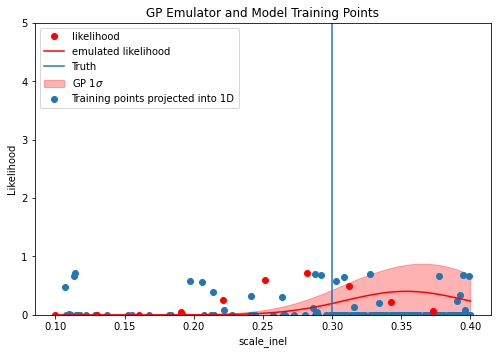

In [425]:
plt.figure(figsize=(7,5))
plt.plot(test_points4[np.arange(0,n_plot_pts,sim_pnt),3], np.exp(simulation_out4[:,0]),'ro', label='likelihood')

#get the GP Emulator's predictions of both the mean and std. deviation
gp_y0, gp_dy0 = emu_predictl(test_points4)

plt.plot(test_points4[:,3], np.exp(gp_y0[:,0]), color='red', label='emulated likelihood')
plt.fill_between(test_points4[:,3], y1 = np.exp(gp_y0[:,0]) - 1.*np.exp(2*gp_y0[:,0] + gp_dy0**2)*(np.exp(gp_dy0**2)-1), y2 = np.exp(gp_y0[:,0]) + 1.*np.sqrt((np.exp(gp_y0[:,0])*gp_dy0)**2), 
                 interpolate=True, alpha=0.3, label=r'GP 1$\sigma$', color='red')

plt.axvline(true_values['scale_inel'],label='Truth')
plt.scatter(gp_array[0].X[:,3],np.exp(gp_array[0].Y),label='Training points projected into 1D')

plt.xlabel(r'scale_inel')
plt.ylabel(r'Likelihood')
plt.title(r'GP Emulator and Model Training Points')
plt.ylim(0,5)
plt.legend()
plt.tight_layout(True)

plt.show()

In [388]:
#make a regular grid to plot our Emulator predictions
n_plot_pts = 100
sim_pnt = 10
test_points5 = np.array([[true_values['alpha_s'],true_values['exponent_inel'],true_values['exponent_el'],
                 true_values['scale_inel'],x] for x in np.linspace(prior_ranges['scale_el'][0],prior_ranges['scale_el'][1],n_plot_pts)])
simulation_out5 = fll(test_points5[np.arange(0,n_plot_pts,sim_pnt),:],pT=pT_obs)#[:,pT_obs]

[[ 0.2        -1.          1.          0.3         0.1       ]
 [ 0.2        -1.          1.          0.3         0.13030303]
 [ 0.2        -1.          1.          0.3         0.16060606]
 [ 0.2        -1.          1.          0.3         0.19090909]
 [ 0.2        -1.          1.          0.3         0.22121212]
 [ 0.2        -1.          1.          0.3         0.25151515]
 [ 0.2        -1.          1.          0.3         0.28181818]
 [ 0.2        -1.          1.          0.3         0.31212121]
 [ 0.2        -1.          1.          0.3         0.34242424]
 [ 0.2        -1.          1.          0.3         0.37272727]]


 <ipython-input-426-118767aea304>:21: MatplotlibDeprecationWarning:Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


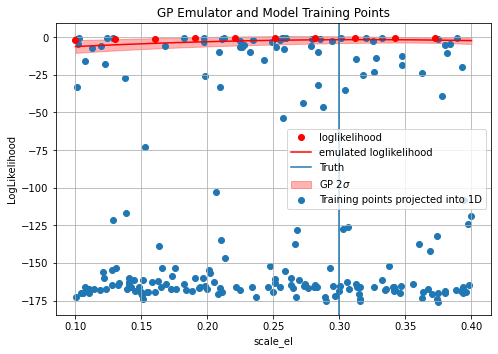

In [426]:
plt.figure(figsize=(7,5))

plt.plot(test_points5[np.arange(0,n_plot_pts,sim_pnt),4], simulation_out5[:,0],'ro', label='loglikelihood')

#get the GP Emulator's predictions of both the mean and std. deviation
gp_y0, gp_dy0 = emu_predictl(test_points5)

plt.plot(test_points5[:,4], gp_y0[:,0], color='red', label='emulated loglikelihood')
plt.fill_between(test_points5[:,4], y1 = gp_y0[:,0] - 2.*gp_dy0, y2 = gp_y0[:,0] + 2.*gp_dy0, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='red')

plt.scatter(gp_array[0].X[:,4],gp_array[0].Y,label='Training points projected into 1D')

plt.axvline(true_values['scale_el'],label='Truth')

plt.xlabel(r'scale_el')
plt.ylabel(r'LogLikelihood')
plt.title(r'GP Emulator and Model Training Points')
plt.legend()
plt.grid(True)
plt.tight_layout(True)

plt.show()

 <ipython-input-427-ac74faa1c2f4>:19: MatplotlibDeprecationWarning:Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


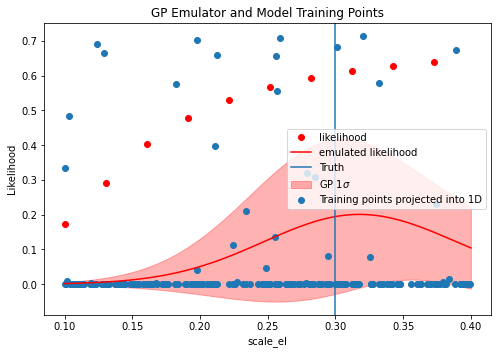

In [427]:
plt.figure(figsize=(7,5))
plt.plot(test_points5[np.arange(0,n_plot_pts,sim_pnt),4], np.exp(simulation_out5[:,0]),'ro', label='likelihood')

#get the GP Emulator's predictions of both the mean and std. deviation
gp_y0, gp_dy0 = emu_predictl(test_points5)

plt.plot(test_points5[:,4], np.exp(gp_y0[:,0]), color='red', label='emulated likelihood')
plt.fill_between(test_points5[:,4], y1 = np.exp(gp_y0[:,0]) - 1.*np.sqrt((np.exp(gp_y0[:,0])*gp_dy0)**2), y2 = np.exp(gp_y0[:,0]) + 1.*np.sqrt((np.exp(gp_y0[:,0])*gp_dy0)**2), 
                 interpolate=True, alpha=0.3, label=r'GP 1$\sigma$', color='red')

plt.axvline(true_values['scale_el'],label='Truth')
plt.scatter(gp_array[0].X[:,4],np.exp(gp_array[0].Y),label='Training points projected into 1D')

plt.xlabel(r'scale_el')
plt.ylabel(r'Likelihood')
plt.title(r'GP Emulator and Model Training Points')
#plt.ylim(0,1)
plt.legend()
plt.tight_layout(True)

plt.show()

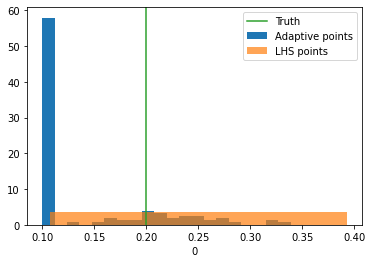

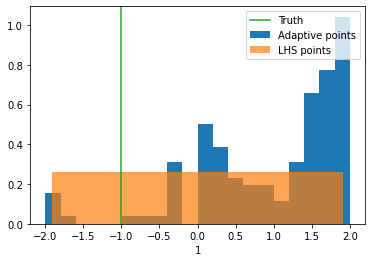

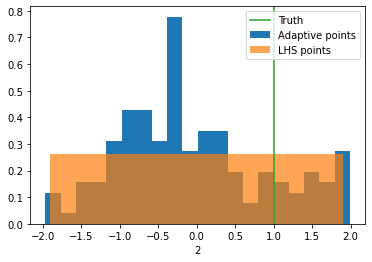

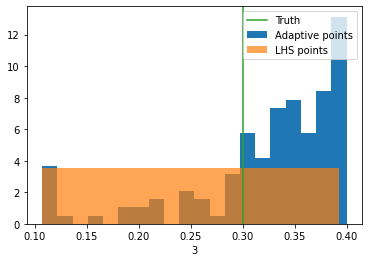

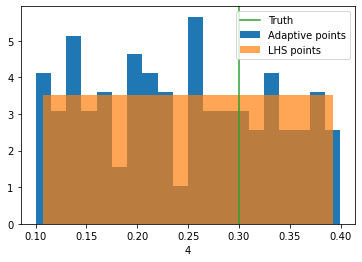

In [404]:
import matplotlib.pyplot as plt

X = model_emukit.X

for i in range(0,5):
    plt.figure()
    plt.hist(X[:,i][20:],bins=20,density=True,label='Adaptive points')
    plt.hist(X[:,i][:20],bins=20,density=True,label='LHS points',alpha=0.7)
    plt.axvline(truth[:,i],color="tab:green",label='Truth')
    
    
    plt.xlabel(str(i))
    plt.legend(loc=1)
    plt.show()

In [406]:
# Define the logprior function
def logPrior(theta):
    
    # Model parameters
    theta = np.array(theta)
    alpha_s, exp_inel, exp_el, sc_inel, sc_el = theta 
    
    # Probability of model parameters: flat prior
    if prior_ranges['alpha_s'][0] < alpha_s < prior_ranges['alpha_s'][1] \
        and prior_ranges['exponent_inel'][0] < exp_inel < prior_ranges['exponent_inel'][1] \
        and prior_ranges['exponent_el'][0] < exp_el < prior_ranges['exponent_el'][1]\
        and prior_ranges['scale_inel'][0] < sc_inel < prior_ranges['scale_inel'][1] \
        and prior_ranges['scale_el'][0] < sc_el < prior_ranges['scale_el'][1]:
        return 0.0
    return -np.inf

In [407]:
def logemulikelihood(theta,x, obs, obserr):
    theta = theta.reshape(-1,5)
    emulike = emu_predictl(theta)#[0]
    #print(emulike)
    return emulike[0]

In [408]:
logemulikelihood(test_points5[0].reshape(-1,5),0,0,0)

array([[-2.59068392]])

In [409]:
# Define logprobability function: l(D|theta) * p(theta)
# Note: use this for emcee, not approxposterior!
def logemuposterior(theta, x, obs, obserr):
        
    lp = logPrior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + logemulikelihood(theta)

In [428]:
ntemps = 25
Tmax = 1e3

nwalkers = 10 #guidance is 10*d
ndim = 5
nburnin = 500
niterations= 1500
nthin = 1#0 # only record every nthin iteration

nthreads = 4

min_theta = np.array([prior_ranges['alpha_s'][0],prior_ranges['exponent_inel'][0],prior_ranges['exponent_el'][0],prior_ranges['scale_inel'][0],prior_ranges['scale_el'][0]])
max_theta = np.array([prior_ranges['alpha_s'][1],prior_ranges['exponent_inel'][1],prior_ranges['exponent_el'][1],prior_ranges['scale_inel'][1],prior_ranges['scale_el'][1]])

# Data and uncertainties that we use to condition our model
args = (x, obs, obserr) # recall x = np.array(pT_obs)

ptsampler=ptemcee.Sampler(nwalkers, ndim, logemulikelihood, logPrior, ntemps, 
                  threads=nthreads, Tmax=Tmax, loglargs=args)

# Making the sampling multi-threaded is as simple as adding the threads=Nthreads 
# argument to PTSampler. 

# First, we run the sampler for 1000 burn-in iterations:
pos0 = np.random.uniform(min_theta, max_theta, (ntemps, nwalkers, ndim))

print("Running burn-in phase")
for p, lnprob, lnlike in ptsampler.sample(pos0, iterations=nburnin,adapt=True):
    pass
ptsampler.reset()

print("Running MCMC chains")
#Now we sample for nwalkers*niterations, recording every nthin-th sample:
for p, lnprob, lnlike in ptsampler.sample(p, iterations=niterations, thin=nthin,adapt=True):
    pass 

print('Done MCMC')

mean_acc_frac = np.mean(ptsampler.acceptance_fraction)
print(f"Mean acceptance fraction: {mean_acc_frac:.3f}",
      f"(in total {nwalkers*niterations} steps)")

Running burn-in phase
Running MCMC chains
Done MCMC
Mean acceptance fraction: 0.311 (in total 15000 steps)


In [429]:
chain_emu = ptsampler.chain[0, :, :, :].reshape((-1, ndim))

In [430]:
import corner

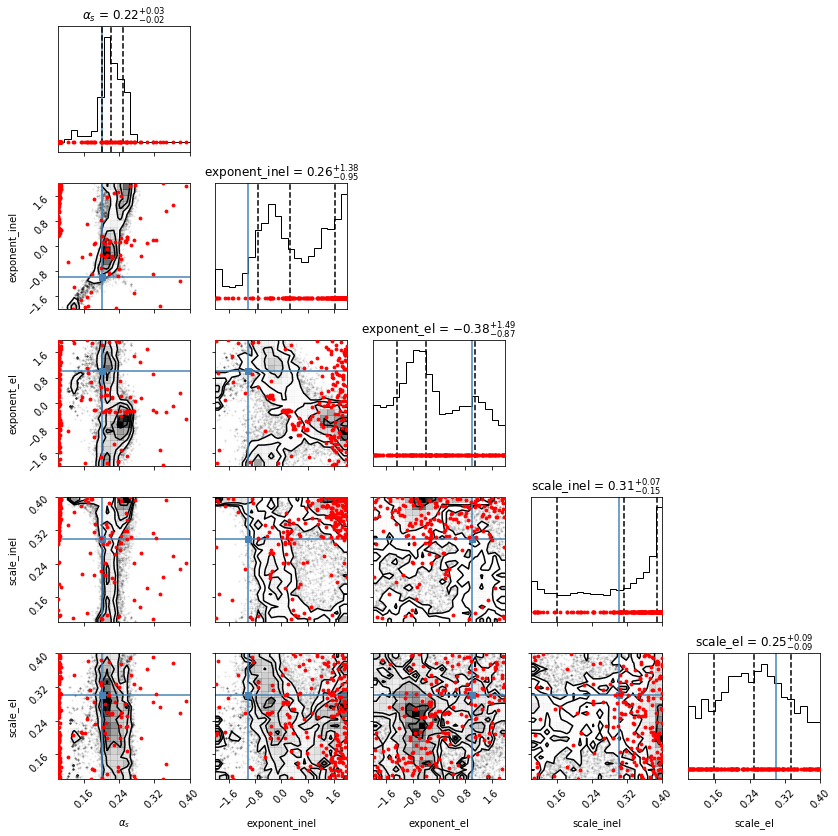

In [431]:
fig = corner.corner(chain_emu, quantiles=[0.16, 0.5, 0.84], truths=truth.T,
                    labels=[r"$\alpha_s$", 'exponent_inel', 'exponent_el','scale_inel','scale_el'], show_titles=True, scale_hist=True,
                    plot_contours=True, range=(prior_ranges.values()));

# Plot where forward model was evaluated
for row in range(0,5):
    for column in range(0,row+1):
        i=5*row+column
        if row == column:
            fig.axes[i].scatter(model_emukit.X[:,row],np.zeros(model_emukit.X[:,row].shape), s=8, color="red", zorder=20)
        else:
            fig.axes[i].scatter(model_emukit.X[:,column], model_emukit.X[:,row], s=8, color="red", zorder=20)

plt.tight_layout()
#plt.savefig('corner-expemulike-ptemcee-20ptLHS-expwt-divcovexp.png',dpi=600)
plt.show()

### This leads us to the obvious result: reducing the exponentiated IMSE.

Again we see that the exponentiation drives all other regions and their uncertainty to 0. Thus in order to do a better job, we need to write a method that exponentiates the GP before moving forward. As it stands, this result is pretty fantastic in that it behaves exactly as I expected and it still gets the peak quite close, but with such uncertainty as to be useless

We also see when we exponentiate that very few points are actually placed in regions of higher likelihood, but are rather scattered evenly across the loglikelihoods. This tells us very clearly where we expect these gains. 

Worth noting as well is that when the IMSE loglikelihood isn't very well trained, the biggest gains in the exponentiated IMSE will happen in regions that will actually have low likelihood, but this will at least start to remedy some of the bias. Really a mixed bag overall.
- scale_el is clearly mean-reverting because of how few relevant training points there are, especially when exponentiated. This means we should actually expect to resolve this behavior but aren't because of our emulation.
- exponent_el is biased, but again this appears to be an effect of the training points.

- Why not just emulate the likelihood and not the loglikelihood? Well, we want to exploit the exponentiation while also keeping our GP error constrained properly. Remember when we exponentiate we propagate the error band according to the variance rule, which is strictly speaking only for uncorrelated errors, so this is a weakness of the above plots.

For Simon: I think this points us in a direction where we have two existing methods which can be combined in a way that may work, but certainly isn't optimal. Even if we decide that a likelihood with GP error is difficult to interpret, it may be worth placing points using some sort of likelihood emulation but then training GPs on the observables at those points.

## Recall that in the loglikelihood emulation with standard IMSE, sklearn was better

Let's see if that holds again given that we're having trouble with overfitting in two parameters and I bet we have the points to fix it.

In [432]:
# Gaussian Process emulation
from sklearn.gaussian_process import GaussianProcessRegressor as GPR #for using Gaussian Processes
from sklearn.gaussian_process import kernels #same
from sklearn.preprocessing import StandardScaler #useful for scaling data

In [436]:
X = model_emukit.X
Y = model_emukit.Y

In [498]:
#this is the 'size' of possible variation of our parameters
ptp = np.array([prior_ranges['alpha_s'][1],prior_ranges['exponent_inel'][1],prior_ranges['exponent_el'][1],prior_ranges['scale_inel'][1],prior_ranges['scale_el'][1]])\
-np.array([prior_ranges['alpha_s'][0],prior_ranges['exponent_inel'][0],prior_ranges['exponent_el'][0],prior_ranges['scale_inel'][0],prior_ranges['scale_el'][0]])

#This is our Squared Exponential Kernel
rbf_kern = 1. * kernels.RBF(
                      length_scale=ptp,
                      length_scale_bounds=np.outer(ptp, (1e-2, 1e5)),
                      )
#This is a white noise kernel, 
#necessary because our physics model has finite statistical accuracy
white_kern = kernels.WhiteKernel(
                         noise_level=.1,
                         noise_level_bounds=(1e-5, 1e1)
                        )

#our kernel is the sum of the Sq. Exponential and White Noise kernels
my_kernel = (rbf_kern + white_kern) 

In [503]:
#first scale our observables 
model_y_copy = np.exp(Y.copy())
scaler = StandardScaler(copy=True).fit(model_y_copy.reshape(-1, 1))
scaled_model_y = scaler.transform(np.exp(Y), copy=True) # the scaled model outputs

In [504]:
#maximizing the GP likelihood proceeds in an iterative process,
#beginning with a random seed. 
#We want to be sure we find a global max., so we restart it several times
nrestarts=10

#define our Gaussian process, and fit it to the hydro model calculations
my_gp = GPR(kernel=my_kernel,
         alpha=0.01, # the nugget, to stabilize matrix inversions
         n_restarts_optimizer=nrestarts, 
         ).fit(X, scaled_model_y)

 /home/mheffernan/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning:The optimal value found for dimension 4 of parameter k1__k2__length_scale is close to the specified upper bound 30000.000000000004. Increasing the bound and calling fit again may find a better value.
 /home/mheffernan/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.


In [505]:
def emu_predictskl(X):
    """This function handles the scaling and GP interpolation together, 
    returning our prediction in the ordinary observable space
    rather than the scaled observable space
    This map is what we call our 'emulator'. """
    scaled_y, scaled_dy = my_gp.predict(X, return_std=True)
    y = scaler.inverse_transform(scaled_y).reshape(len(X))
    dy = scaled_dy * scaler.scale_
    return y, dy

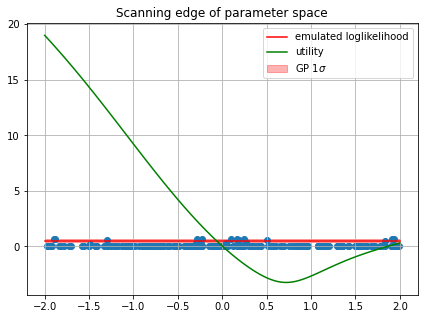

In [506]:
plt.figure(figsize=(7,5))

# let's visualize on some edges

# emutestpts = np.array([[x,-1.99,1.99,0.3,0.3] for x in \
#                        np.linspace(prior_ranges['alpha_s'][0],prior_ranges['alpha_s'][1],n_plot_pts)])

dim = 2
emutestpts = np.array([[0.2,-1,x,0.3,0.4] for x in \
                       np.linspace(-2,2,n_plot_pts)])
gp_y0, gp_dy0 = emu_predictskl(emutestpts)

gp_y0 = gp_y0.reshape(len(emutestpts),-1)


#print(emu_predictl(np.array([emutestpts[0]])))
#print(utility(np.array([x for x in emutestpts])))

utility_min = lambda x: float(-utility(np.array([x]),t='Kandasamy'))

#util_pts = np.array([utility(np.array([x]))  for x in emutestpts]).reshape(1,-1).flatten()

util_pts = np.array([utility_min(x)  for x in emutestpts]).reshape(1,-1).flatten()

#print(np.array(util_pts).reshape(1,-1).flatten())

plt.plot(emutestpts[:,dim], gp_y0[:,0], color='red', label='emulated loglikelihood')
plt.fill_between(emutestpts[:,dim], y1 = gp_y0[:,0] - 1.*gp_dy0, y2 = gp_y0[:,0] + 1.*gp_dy0, 
                 interpolate=True, alpha=0.3, label=r'GP 1$\sigma$', color='red')

#plt.plot(emutestpts[:,0], np.exp(gp_y0[:,0]), color='red', label='emulated likelihood')
#plt.fill_between(emutestpts[:,0], y1 = np.exp(gp_y0[:,0]) - 1.*np.sqrt((np.exp(gp_y0[:,0])*gp_dy0)**2), y2 = np.exp(gp_y0[:,0]) + 1.*np.sqrt((np.exp(gp_y0[:,0])*gp_dy0)**2), 
#                 interpolate=True, alpha=0.3, label=r'GP 1$\sigma$', color='red')

plt.plot(emutestpts[:,dim], util_pts, color='green', label='utility')

plt.scatter(model_emukit.X[:,dim],np.exp(model_emukit.Y))

plt.title('Scanning edge of parameter space')
plt.grid(True)
plt.legend()

plt.show()

In [441]:
# Define the logprior function
def logPrior(theta):
    
    # Model parameters
    theta = np.array(theta)
    alpha_s, exp_inel, exp_el, sc_inel, sc_el = theta 
    
    # Probability of model parameters: flat prior
    if prior_ranges['alpha_s'][0] < alpha_s < prior_ranges['alpha_s'][1] \
        and prior_ranges['exponent_inel'][0] < exp_inel < prior_ranges['exponent_inel'][1] \
        and prior_ranges['exponent_el'][0] < exp_el < prior_ranges['exponent_el'][1]\
        and prior_ranges['scale_inel'][0] < sc_inel < prior_ranges['scale_inel'][1] \
        and prior_ranges['scale_el'][0] < sc_el < prior_ranges['scale_el'][1]:
        return 0.0
    return -np.inf

In [442]:
def logemulikelihoodskl(theta,x, obs, obserr):
    theta = theta.reshape(-1,5)
    emulike = emu_predictskl(theta)#[0]
    #print(emulike)
    return emulike[0]

In [443]:
def logemuposterior(theta, x, obs, obserr):
        
    lp = logPrior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + logemulikelihoodskl(theta,x, obs, obserr)

In [306]:
ntemps = 25
Tmax = 1e3

nwalkers = 10 #guidance is 10*d
ndim = 5
nburnin = 200
niterations= 1500
nthin = 1#0 # only record every nthin iteration

nthreads = 4

min_theta = np.array([prior_ranges['alpha_s'][0],prior_ranges['exponent_inel'][0],prior_ranges['exponent_el'][0],prior_ranges['scale_inel'][0],prior_ranges['scale_el'][0]])
max_theta = np.array([prior_ranges['alpha_s'][1],prior_ranges['exponent_inel'][1],prior_ranges['exponent_el'][1],prior_ranges['scale_inel'][1],prior_ranges['scale_el'][1]])

# Data and uncertainties that we use to condition our model
args = (x, obs, obserr) # recall x = np.array(pT_obs)

ptsamplerskl=ptemcee.Sampler(nwalkers, ndim, logemulikelihoodskl, logPrior, ntemps, 
                  threads=nthreads, Tmax=Tmax, loglargs=args)

# Making the sampling multi-threaded is as simple as adding the threads=Nthreads 
# argument to PTSampler. 

# First, we run the sampler for 1000 burn-in iterations:
pos0 = np.random.uniform(min_theta, max_theta, (ntemps, nwalkers, ndim))

print("Running burn-in phase")
for p, lnprob, lnlike in ptsamplerskl.sample(pos0, iterations=nburnin,adapt=True):
    pass
ptsampler.reset()

print("Running MCMC chains")
#Now we sample for nwalkers*niterations, recording every nthin-th sample:
for p, lnprob, lnlike in ptsamplerskl.sample(p, iterations=niterations, thin=nthin,adapt=True):
    pass 

print('Done MCMC')

mean_acc_frac = np.mean(ptsamplerskl.acceptance_fraction)
print(f"Mean acceptance fraction: {mean_acc_frac:.3f}",
      f"(in total {nwalkers*niterations} steps)")

Running burn-in phase
Running MCMC chains
Done MCMC
Mean acceptance fraction: 0.299 (in total 15000 steps)


In [307]:
chain_emuskl = ptsamplerskl.chain[0, :, :, :].reshape((-1, ndim))

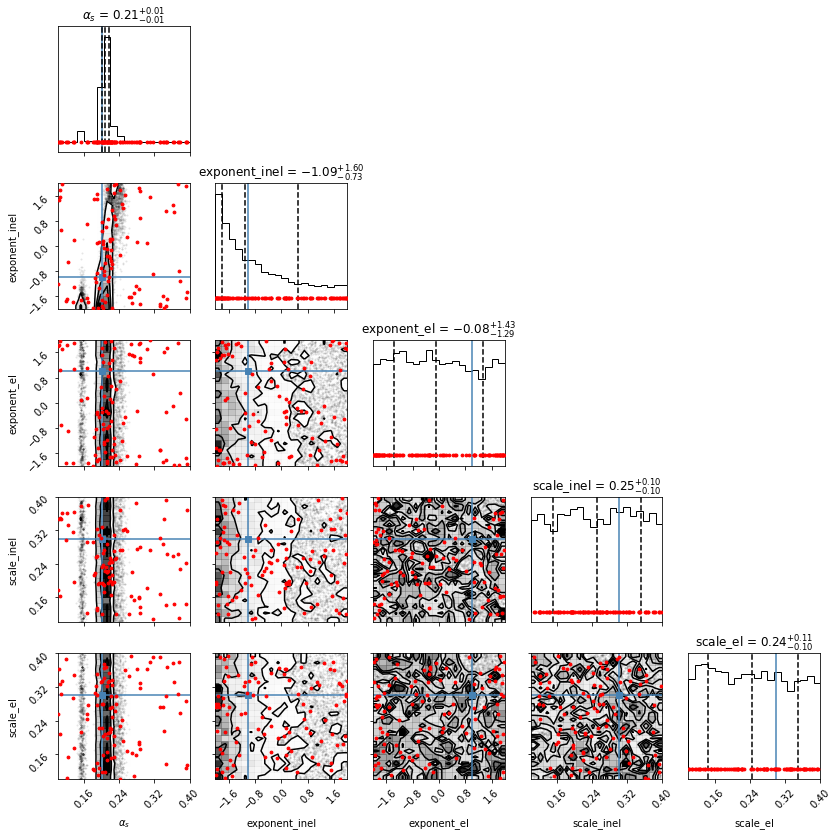

In [309]:
fig = corner.corner(chain_emuskl, quantiles=[0.16, 0.5, 0.84], truths=truth.T,
                    labels=[r"$\alpha_s$", 'exponent_inel', 'exponent_el','scale_inel','scale_el'], show_titles=True, scale_hist=True,
                    plot_contours=True, range=(prior_ranges.values()));

# Plot where forward model was evaluated
for row in range(0,5):
    for column in range(0,row+1):
        i=5*row+column
        if row == column:
            fig.axes[i].scatter(model_emukit.X[:,row],np.zeros(model_emukit.X[:,row].shape), s=8, color="red", zorder=20)
        else:
            fig.axes[i].scatter(model_emukit.X[:,column], model_emukit.X[:,row], s=8, color="red", zorder=20)


plt.tight_layout()
#plt.savefig('corner-expemulikeskl-ptemcee.png',dpi=600)
plt.show()